In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 627 Project 2
## Statoil/C-CORE Iceberg Classifier Challenge
- Author: Zhongyu Liu, Yan Ting Chen
- Data: 12/09/2017
- Objective: Use CNN to process image data and predict output to determine ice berg or ship.
- Index:
    - I. [Image Process and Analysis: Preprocess images and analysis feature 'inc_angle'](http://localhost:8888/notebooks/proj2/627_Project2/Project2.ipynb#Section-I)<br>
    - II. [Model Building: Test multi-layer model and adujst parameters](http://localhost:8888/notebooks/proj2/627_Project2/Project2.ipynb#Section-II)<br>
    - III. [Actual Performance: Generate submission code](http://localhost:8888/notebooks/proj2/627_Project2/Project2.ipynb#Section-III)<br>
    - IV. [Submission Report: Detail report for each submission](http://localhost:8888/notebooks/proj2/627_Project2/Project2.ipynb#Section-IV)<br>

## Section I
### Image Process and Analysis

In this section, we preprocess the image, and analyize the only feature 'inc_angle'. I also go over some visulization of the iceberg data to see is there anything helpful, may be can help us to understand what features might be useful.

##### 1.0 Packages import
As normal, first of all we have to input everything that's useful, in this notebook, I try not to import everything in the single cell since they all serve different purpose and it's gonna be mess if they all in one cell. For the cell below will be some package that I used the most, and others will be locate right above when I require to use them.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from scipy import signal # use for smooth image

import os

##### 1.1 Help fucntions
We write some help function for us to better analysis the data. Please see comment in each function for it's detail purpose.

In [3]:
# Help function to read in the data and process
def read_jason(file_path):
    # Read file with panda json
    df = pd.read_json(file_path)
    # convert bad value to a floating point format with the NaN values left in.
    df['inc_angle'] = pd.to_numeric(df['inc_angle'],errors='coerce')
    return df

In [4]:
# Help function to process, reshape the data and generate the trianing data
def get_data(df):
    # reshape bands, and convert to float32
    band1 = array([array(band).astype(float32).reshape(75, 75) for band in df["band_1"]])
    band2 = array([array(band).astype(float32).reshape(75, 75) for band in df["band_2"]])
    plus = (band1+band2)
    # Combaine the train data with band1, band2, and sum of band1 and band2, 
    # add newaxis in each band to generate train data shape of (?,75,75,3).
    train = concatenate([band1[:,:,:,newaxis], band2[:,:,:,newaxis], plus[:,:,:,newaxis]], axis=-1)
    # Since no need the band data in table, drop them
    df = df.drop(['band_1', 'band_2'], axis=1)
    return df, train

In [5]:
# Help function to show plot, just want to see what the data looks like
# for parameter show, it's just indicate which band to show, 0: band1, 1: band2, 2:sum.
def display_plt(data, bands, test=False, show=2):
    figsize(16,8)
    res = ['Ship', 'Ice_Berg']
    for idx, band in enumerate(bands[:,:,:,show]):
        subplot(2,5,idx+1)
        imshow(band)
        name = 'Angle ' + str(data.inc_angle[idx]) 
        title(name)
        if not test:
            xlabel('True:'+ res[data.is_iceberg[idx]])

##### 1.2 Load data
First, we read the train and test data using the help function above, and process them to generate the X_train data we need.

At very fist I didn't think about conbine the data, I trained them seperate and result is awful, so I try to combine them and train. After a few attemp, I realize there should be some connection about band1 and band2 so I try to add them together, better result shows I'm on the right trick.

In [6]:
# train data path
json_path = 'data/processed/train.json'
train, X_train = get_data(read_jason(json_path))
# test data path
test_json_path = 'data/processed/test.json'
test, X_test = get_data(read_jason(test_json_path))


Before we go deeper, we want to display some sample image to see what's data looks like, which required the display_plt function above. I pull out 10 image each from train and test data.

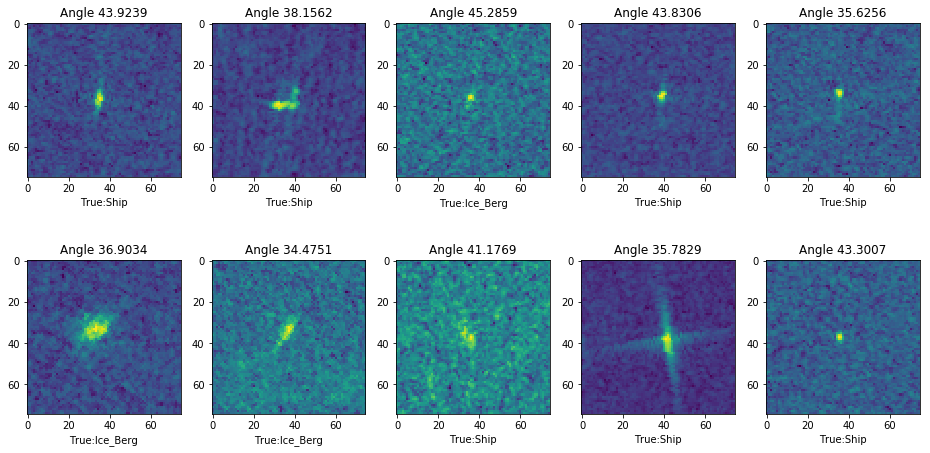

In [7]:
# display sample train data
display_plt(train, X_train[:10])

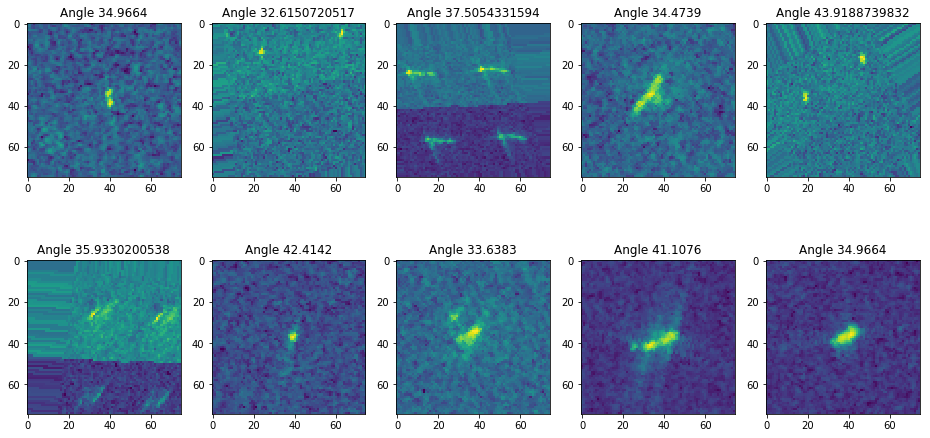

In [8]:
# display sample test data
display_plt(test, X_test[:10], test=True)

Just eyeballing them I can't really tell what is what, and also, I realize that test data is way messer than the train data. The data is more nosisy and they might be more than one object in the image. Like in test data row 1 col 3, instead of 1 there's 4 objects in the image... Also, if we compare with data size.

In [9]:
print 'trian data size:', len(train), ', test data size:', len(test), '.'

trian data size: 1604 , test data size: 8424 .


We can see that test data have about 5 times bigger than the train data set. So I think we should get more data to train with, well, we have to generate more data to train with.

##### 1.3 Feature analysis
For missing data (inc_angle), there are 133 data missing in the train data set. At begining I set all of them to -1 but when ploting it's gives me a lot of trouble so I just change them to float type.

Since this is the only feature we have, I figure it should have some effection to decide is the image ice berg or ship. but result shows that number of angle won't effect that much, maybe it can use to combine the two band? But as we can see from the image shown below, it won't effect that much on determine the type of object.

In [10]:
print 'Number of missing value in train data set is:', sum([math.isnan(x) for x in train.inc_angle]), '.'

Number of missing value in train data set is: 133 .


/home/liuz10/miniconda2/envs/srp/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/liuz10/miniconda2/envs/srp/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


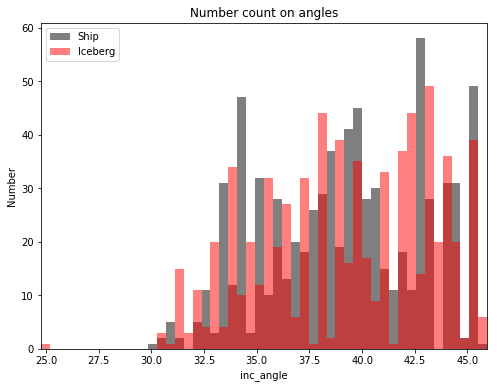

In [11]:
# feature analysis, display histgram for better virtrulization
figsize(8,6)
# plot histgram for ship
hist(train.loc[train.is_iceberg==1,'inc_angle'],range=[train.inc_angle.min(),train.inc_angle.max()],
     bins=50,color='black',alpha=0.5,label='Ship')
# plot histgram for ice berg
hist(train.loc[train.is_iceberg==0,'inc_angle'],range=[train.inc_angle.min(),train.inc_angle.max()],
     bins=50,color='red',alpha=0.5,label='Iceberg')
legend()
title('Number count on angles')
xlim([train.inc_angle.min(),train.inc_angle.max()])
xlabel('inc_angle')
ylabel('Number')

##### 1.4 Preprocess Image

By plotting the data, we can see that there are some bunch of noise in the image, and we think is the best to preprocess the image before we train them, In this subsection, we would introduce two way we tried to making the image better.

###### 1.4.1 Image Smoothing
We try to remove the noisy by smooth the image use signal.convolve2d in the scipy package, below is some help function we build. 

In [12]:
# Help function to generate the new smoothed train data with old train data.
def smoooooth(data):
    b1 = go_smooth(data[:,:,:,0])
    b2 = go_smooth(data[:,:,:,1])
    b3 = go_smooth(data[:,:,:,2])
    
    return concatenate([b1[:,:,:,newaxis], b2[:,:,:,newaxis], b3[:,:,:,newaxis]], axis=-1)
    
# Help function to smooth each image if needed.
def go_smooth(data):
    return array([get_smooth(d) for d in data])

# Help function to smooth one image use package convolve2d
def get_smooth(data, smooth=np.array([[1,1,1],[1,5,1],[1,1,1]])):
    return signal.convolve2d(data, smooth, mode='same')

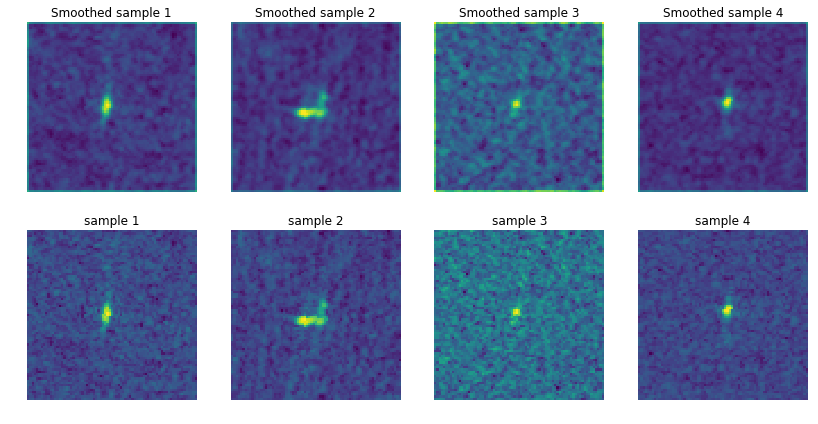

In [13]:
# pick some sample data to comput
sample_img = X_train[:4,:,:,2]
sample_img_smoothed = go_smooth(sample_img)
figsize(14, 7)
for idx, i in enumerate(range(1, 5)): 
    subplot(2,4,i)
    imshow(sample_img_smoothed[idx])
    title('Smoothed sample ' + str(i))
    axis('off')
    subplot(2,4,4+i)
    imshow(sample_img[idx])
    title('sample ' + str(i))
    axis('off')

As we can see, since the size is changing after reshape, there's a outline around the smoothed image, I don't really know the how the score gonna effect so I'm just gonna try.

In [14]:
# Generate smoothed X_train
smoothed_X_train = smoooooth(X_train)

###### 1.4.2 Denoising Image

Except smooth, we also tried denoising image. We tried to use ndimage from scipy package. 

In [15]:
from scipy import ndimage

In [16]:
# Help function to generate the new denoising train data with old train data.
def denoises(data):
    b1 = go_smooth(data[:,:,:,0])
    b2 = go_smooth(data[:,:,:,1])
    b3 = go_smooth(data[:,:,:,2])
    
    return concatenate([b1[:,:,:,newaxis], b2[:,:,:,newaxis], b3[:,:,:,newaxis]], axis=-1)
    
# Help function to smooth each image if needed.
def go_denoise(data):
    return array([get_denoise(d) for d in data])

# Help function to smooth one image use package convolve2d
def get_denoise(data, size=3):
    return ndimage.median_filter(data, size)

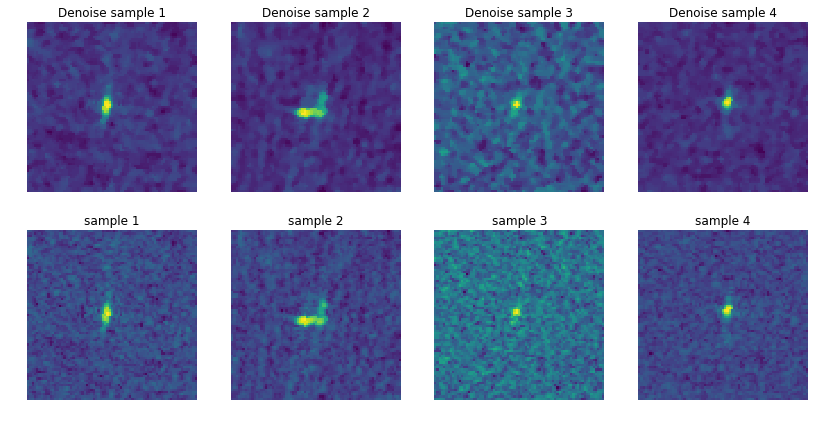

In [17]:
# Same, we are using the same 1-4 sample to show the denoising part.
sample_img_denoise = go_denoise(sample_img)
figsize(14, 7)
for idx, i in enumerate(range(1, 5)): 
    subplot(2,4,i)
    imshow(sample_img_denoise[idx])
    title('Denoise sample ' + str(i))
    axis('off')
    subplot(2,4,4+i)
    imshow(sample_img[idx])
    title('sample ' + str(i))
    axis('off')

In [18]:
# Generate smoothed X_train
denoise_X_train = denoises(X_train)

##### 1.5 Size Matters

As we showed on very top, train data set is 5 times smaller than test data set. Which it not usual, in submission detail, we can see that when use given data the size, the log loss result increase a lot when we generate more data and train on them, now on we only add data that flip the data by horizontal, by vertical and by diagonal. May be I'll include rotation too to see is it gonna be helpful. From sample output, we can see that if object is a ship, is not always face in the same direction, it's possible to face anywhere. So train on more of this data should be helpful, and result shown prove.

After a few attemp, we find out that adding rotated data will effect the training, but not the good way, so we remove the code to creat rotate data, but still left display part for comparsion.

In [19]:
from scipy.ndimage.interpolation import rotate

(-0.5, 74.5, 74.5, -0.5)

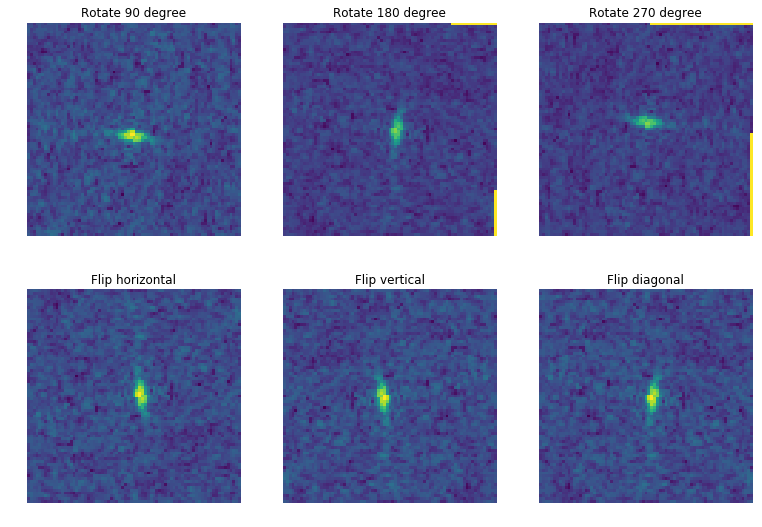

In [20]:
# Apply on sample image 1, to show change we apply to the image.
sample = X_train[0,:,:,2]
figsize(13, 9)
subplot(2,3,1)
imshow(rotate(sample, 90))
title('Rotate 90 degree')
axis('off')
subplot(2,3,2)
imshow(rotate(sample, 180))
title('Rotate 180 degree')
axis('off')
subplot(2,3,3)
imshow(rotate(sample, 270))
title('Rotate 270 degree')
axis('off')
subplot(2,3,4)
imshow(fliplr(sample))
title('Flip horizontal')
axis('off')
subplot(2,3,5)
imshow(flipud(sample))
title('Flip vertical')
axis('off')
subplot(2,3,6)
imshow(flipud(fliplr(sample)))
title('Flip diagonal')
axis('off')

In [21]:
# Help function to combine layers, Just we used a lot so function seems helpful.
def concatenate_data(a,b,c):
    return concatenate([array(a)[:,:,:,newaxis], array(b)[:,:,:,newaxis], array(c)[:,:,:,newaxis]], axis=-1)

In [22]:
# Help function to generate more data.
def generate_more(data):
    res = [data]
    
    # flap all layer horizontally
    nb1, nb2, ns = [], [], []
    for idx in range(len(data)):
        nb1.append(fliplr(data[idx,:,:,0]))
        nb2.append(fliplr(data[idx,:,:,1]))
        ns.append(fliplr(data[idx,:,:,2]))
    res.append(concatenate_data(nb1, nb2, ns))
    
    # flap all layer vertically
    nb1, nb2, ns = [], [], []
    for idx in range(len(data)):
        nb1.append(flipud(data[idx,:,:,0]))
        nb2.append(flipud(data[idx,:,:,1]))
        ns.append(flipud(data[idx,:,:,2]))
    res.append(concatenate_data(nb1, nb2, ns))
    
    # flap all layer diagonally
    for idx in range(len(nb1)):
        nb1[idx]=fliplr(nb1[idx])
        nb2[idx]=fliplr(nb2[idx])
        ns[idx]=fliplr(ns[idx])
    res.append(concatenate_data(nb1, nb2, ns))
    
    return concatenate(res)

###### 1.6 Generate Labels.
This part is pretty stright forward, we generate the train data under differnt situation, and then generate the corrisponding label data base on train data.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [73]:
# if smoothed is True, use the train data that smoothed, else, use normal data to generate more data.
smoothed = False
denoise = True
more = True
if more:
    if smoothed:
        more_X_train = generate_more(smoothed_X_train)
    elif denoise:
        more_X_train = generate_more(denoise_X_train)
    else:
        more_X_train = generate_more(X_train)
else:
    more_X_train = X_train

In [74]:
# Generate initial label
y_train=train['is_iceberg']
# Generate corrisponding label with same size of train data
more_y_train = concatenate([y_train for i in range(len(more_X_train)/len(X_train))])
# Just checking the shape
print 'train data shape:', more_X_train.shape
print 'label data shape:', more_y_train.shape

train data shape: (6416, 75, 75, 3)
label data shape: (6416,)


In [75]:
# Generate X_train and y_train with train_test_split method from sklearn
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(more_X_train, more_y_train, 
                                                            random_state=517, train_size=.75)

## Section II
### Model Building
At very begining we decide to use tensorflow, to begin with, we modify the code from lab. It works and generate our first entry, which is not very good. When we reseraching and try to add more layer, we discoverd keras and personally I realize keras is easier to implement and use than tensorflow. So we decide to switch to keras, but still using tensorflow as background, and it's working perfectly. 

We did a lot of modifications when building model, and we tried a lot of different combiation of parameters, please see detail submission about what we change in time to get better score.

##### 2.1 Set up a CNN 

In [76]:
# We are going to use keras, run on tensorflow background to train the data.
# from keras import initializers
from keras import backend as K
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential # initial model
from keras.layers import Input, Flatten, Activation, Dropout
from keras.layers import MaxPooling2D, Dense, Conv2D
from keras.layers import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau # Use callback to save time.

import tensorflow as tf

In [77]:
# Initial a tensorflow session and set at backend for keras
sess = tf.Session()
K.set_session(sess)

In [78]:
def getModel():
    # initial model
    model = Sequential()
    
    # add conv layer 1
    model.add(BatchNormalization(input_shape=(75,75,3)))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.2))

    # add conv layer 2
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))
    
    # add conv layer 3
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    # add conv layer 4
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))
    
    # Flatten the data
    model.add(Flatten())

    # Dense Layer 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    
    # Dense Layer 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Sigmoid layer
    model.add(Dense(1, activation='sigmoid'))

    # compile
    mypotim=Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=mypotim, metrics=['accuracy'])
    model.summary()
    
    return model

In [79]:
# help function for callbacks
def get_callbacks(filepath, patience=2):
    # Set to earlystop to stop the training early to save time
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    # save model checkpoint.
    msave = ModelCheckpoint(filepath, save_best_only=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, mode='min')
    return [es, msave, reduce_lr_loss]

file_path = ".new_model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=7)

##### 2.2 Fit model
Just simple code that fit the model the output history of model performance, which can be use to generate performance plot.

In [ ]:
model = getModel()
history = model.fit(X_train_cv, y_train_cv, batch_size=36, epochs=50, verbose=1,
                    validation_data=(X_valid, y_valid), callbacks=callbacks)
print 'we done!'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 75, 75, 3)         12        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 17, 17, 128)       0         
__________

##### 2.3 Check Model Performance

In [67]:
model.load_weights(filepath=file_path)
score = model.evaluate(X_valid, y_valid, verbose=1)

print 'Test loss:', score[0]
print 'Test accuracy:', score[1]

1604/1604 [==============================] - 3s 2ms/step
Test loss: 0.167973486656
Test accuracy: 0.930798004988


In [33]:
# Help function to generate performance plot. 
# Display model accuracy and model loss
def generate_fig(history, train, test, save='False'):
    plt.plot(history.history[train])
    plt.plot(history.history[test])
    if train == 'acc':
        plt.title('model accuracy')
        plt.ylabel('accuracy')
    else:
        plt.title('model loss')
        plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    if save:
        fname = str(len(history.history[train])) + '_epochs_' + train
        plt.savefig(fname)
    plt.show()

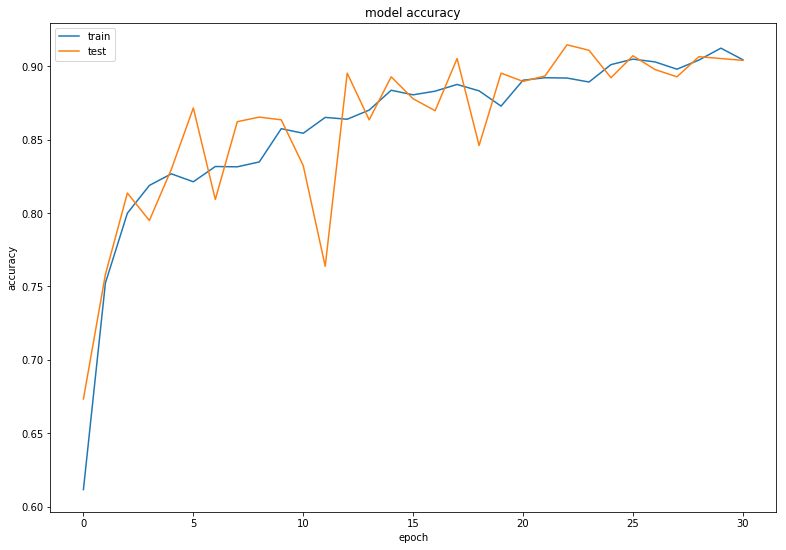

In [34]:
# Generate accuracy plot
generate_fig(history, 'acc', 'val_acc', save=True)

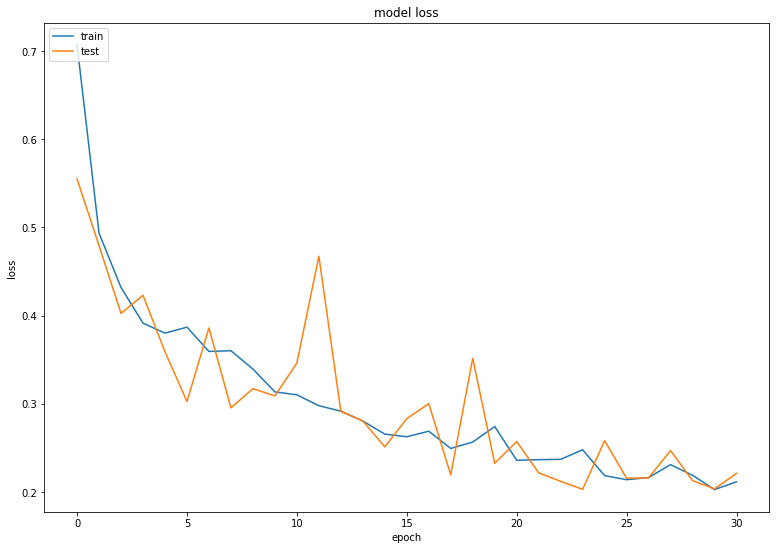

In [35]:
# generate model loss
generate_fig(history, 'loss', 'val_loss', save=True)

## Section III
### Actual Performance
Just simple section to generate prediction result and save to csv file for submission. 

In [70]:
# Pre-process the test data if needed.
if smoothed:
    print 'Before prediction, we need to preprocess the test image by smoothing them.'
    X_test = smooooth(X_test)
elif denoise:
    print 'Before prediction, we need to preprocess the test image by denoising them.'
    X_test = denoises(X_test)
else:
    print 'Image do not need to be processed before prediction.'

Image do not need to be processed before prediction.


In [71]:
# Predict on the test data
pred = model.predict_proba(X_test)

8424/8424 [==============================] - 15s 2ms/step


In [72]:
res_table = pd.DataFrame()
res_table['id'] = test['id']
res_table['is_iceberg'] = pred.reshape(pred.shape[0])
# Save into a csv file, remember to change name of file
CSV_FILE='/home/liuz10/Desktop/res_12_10_04.csv'
res_table.to_csv(CSV_FILE, index=False)

## Section IV
### Submission Report
In this section, please find detail submission report on each submition, and changes in between each submission.

First Submission:
- CNN: Tensorflow
- Logloss: 22.46
- Layers: Just basic layer and model structure from labs.
- Detail: This submission is the first attempt to check our model, it's working so we made the first attempt, it really really bad but we kind knows that already, no surprise here.

Second Submission:
- CNN: Keras
- Logloss: 0.2599
- Layers: Sequential, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
- Detail: Switch CNN model from tensorflow to keras, but still using tensorflow as backend. We declare model sequential as initial model, then adding cov2D as input layer and maxpooling2d layer with dropout layer to protect from overfitting, Maxpooling is use to reduce the number of parameters in our model by sliding a 2x2 pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter. And then we flatten the model, then use dense as fully connected layer and final generate the output layer. It's pretty basic keras model, and the result came out nicly. 

Third Submission:

- CNN: Keras
- Logloss: 0.2146
- Layers: Finalize input parameters on model layers
- Detail: With our current model, we tested on a lot of layer combinations, by changing the input size, pooling size and strides. Since we are new to this, we are doing a lot of work research and came up with our final result that works the best. We run hundreds of tests and compare them With the current model set. Also, we used callback and earlystopping to save more time on training.

Forth Submission:
- CNN: Keras
- Logloss: 0.1691 (About rank 500 in the leaderboard)
- Layers: Current model with batch normorlization
- Features: duplicate train data size
- Detail: After decide the model, we think we should work on a different angle to reduce logloss. Here is when we test on generate more train data. We think that small size of training data will effect the result. Which turns out right. With the original data set, we generate the new data set include original, filp horizontal on original, filp vertical on original, and filp diagnoal on original. We also generate correct label that matches training data. Result came out nicely. We jump in about range 500 on the leaderboard. Which is a big step by just increase train data size.

Thing we changed but not submit:
- Beside all this, we also tried to incude more and different layers, such as globalMaxpooling and such, we also tested on smooth and denoising, performacne result is not really imporve the final score (we submitted but score it worse than before so we didn't include in the submission detail). Since we did this report over times and sort of loss some detail information on the specific detail changes. But you can locate the detail code of smooth and denoising in [preprocess image](http://localhost:8888/notebooks/proj2/627_Project2/Project2.ipynb#1.4-Preprocess-Image). If we got more time I think we'll test on more detail and maybe think about a new way to preprocess the image data. Smooth and denosing are the only thing we tried but both of them not really work ideally... 